In [1]:
import json
import requests as rq
import pandas as pd
import numpy as np
import time
import itertools
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
G=nx.Graph()
import pymongo
from pymongo import MongoClient
import community

egonets_data = pd.read_csv('egonets_data.csv')

In [2]:
egonets_data['num_communities'] = egonets_data['num_communities']/egonets_data['Summ_totalGames']
egonets_data['num_components'] = egonets_data['num_components']/egonets_data['Summ_totalGames']
egonets_data['node_density_test'] = egonets_data['AVG_degree']/egonets_data['Summ_totalGames']

In [4]:
variable_names = ['Modularity', 'Components', 'Coverage', 'Giant_Component_Coverage', 
                  'AVG_degree','Perc_Important_Nodes', 'AVG_centrality']

egonets_data_numeric = egonets_data.iloc[:,[3,4,6,7,8,9,10]]
X = egonets_data_numeric.values

In [7]:
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import cluster
import yellowbrick
from sklearn.cluster import MiniBatchKMeans, KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

C:\ProgramData\Anaconda\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
X_std = StandardScaler().fit_transform(X)

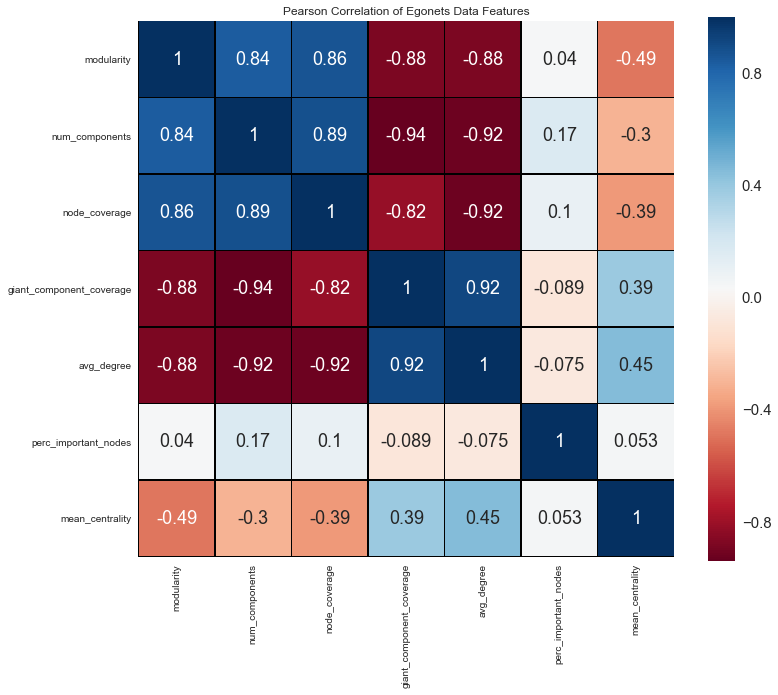

In [9]:
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
plt.title('Pearson Correlation of Egonets Data Features')
# Draw the heatmap using seaborn
sns.set(font_scale = 1.5)
sns.heatmap(egonets_data_numeric.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="RdBu", linecolor='black', annot=True)

Estimated number of clusters: 7
Silhouette Coefficient: 0.533


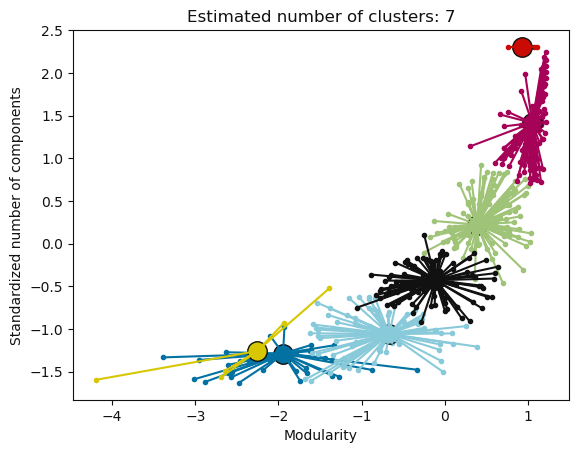

In [26]:
X = X_std

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-45, damping = 0.8).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle
plt.style.use('default')
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('Modularity')
plt.ylabel('Standardized number of components')
plt.show()

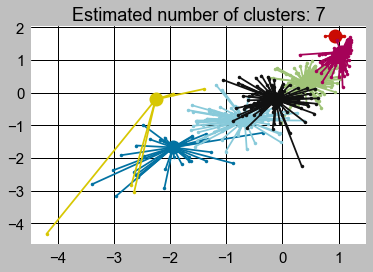

In [18]:
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 2], col + '.')
    plt.plot(cluster_center[0], cluster_center[2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[2], x[2]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [12]:
egonets_data_numeric.describe()

,modularity,num_components,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality
count,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000
mean,0.783327,0.417938,0.732058,0.432795,3.682725,0.024961,0.001242
std,0.176742,0.252734,0.155142,0.266273,0.439309,0.094651,0.004472
min,0.042192,0.005525,0.061594,0.005185,3.000000,0.001738,0.000000
25%,0.678632,0.218372,0.636630,0.206246,3.349877,0.007884,0.000052
50%,0.821265,0.391304,0.754545,0.418919,3.628105,0.011976,0.000222
75%,0.921576,0.606439,0.846300,0.632663,3.926603,0.019070,0.000809
max,0.998764,1.000000,1.000000,1.000000,6.235294,1.000000,0.046569


In [13]:
egonets_data.iloc[:,[5]].describe()

,density
count,439.000000
mean,0.009331
std,0.026731
min,0.000417
25%,0.001724
50%,0.003220
75%,0.006770
max,0.389706


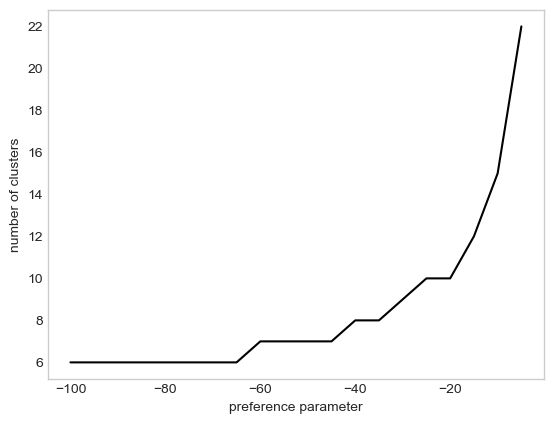

In [25]:
i = -100
x = []
y = []
while i < 0:
    af = AffinityPropagation(preference=i, damping = 0.8).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    x.append(i)
    y.append(n_clusters_)
    i = i + 5

plt.style.use('grayscale')
sns.set_style("whitegrid")
plt.grid(False)
plt.xlabel('preference parameter')
plt.ylabel('number of clusters')
plt.plot(x,y)
plt.savefig('preference_SON.png', bbox_inches='tight')
plt.show()